In [1]:
import numpy as np
from scipy import ndimage
import tensorflow as tf
from os import listdir

#has package pillow as a dependency. Is needed to give scipy image operations. 
from scipy import misc
import scipy

from modules.utils import *
from modules.model import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import modules.vgg.vgg19 as vgg19
vgg1 = vgg19.Vgg19(vgg19_npy_path="data/vgg19.npy")
vgg2 = vgg19.Vgg19(vgg19_npy_path="data/vgg19.npy")

npy file loaded
npy file loaded


In [3]:
'''Constants'''
IMAGE_FOLDER = "data/anime wallpapers"

BATCH_SIZE = 1 #Shouldn't be changed
SCALE = 2
EPOCHS = 35

INPUT_SIZE = Dimensions(500, 500)
OUTPUT_SIZE = Dimensions(INPUT_SIZE.h*SCALE, INPUT_SIZE.w*SCALE)


COMP_PATCH = Dimensions(224,224)
COMP_STRIDES = Dimensions(200,200)
#To be improved because not all of image will be seen. Change with care
COMP_RATES = Dimensions(1,1)




LEARNING_RATE = 0.001

In [4]:
'''Load data'''
image_png_names = listdir(IMAGE_FOLDER + "/png")
image_nb_names = listdir(IMAGE_FOLDER + "/no_blurry")
image_jpg_names = listdir(IMAGE_FOLDER + "/jpg")
num_pngs = len(image_png_names)
num_jpgs = len(image_jpg_names)
image_png_paths = [IMAGE_FOLDER + '/png/' + name for name in image_png_names]
image_nb_paths = [IMAGE_FOLDER + '/no_blurry/' + name for name in image_nb_names]
image_jpg_paths = [IMAGE_FOLDER + '/jpg/' + name for name in image_jpg_names]

In [5]:
def upscaler(in_tensor, in_channels, f_1, f_r, f_u, out_channels):
    upscale_model = Model("Upscaler", in_tensor)
    upscale_model.full_conv2d(3,f_1)
    upscale_model.relu()

    upscale_model.add_residual_block(f_1,f_r)
    upscale_model.add_residual_block(f_r,f_r)
    upscale_model.add_residual_block(f_r,f_r)
    upscale_model.add_residual_block(f_r,f_r)
    upscale_model.add_residual_block(f_r,f_r)
    upscale_model.add_residual_block(f_r,f_r)

    '''
    upscale_model.upscale([OUTPUT_SIZE.h//2,OUTPUT_SIZE.w//2])
    upscale_model.full_conv2d(f_r,f_u, mapsize=3)
    upscale_model.relu()
    '''
    
    upscale_model.upscale([OUTPUT_SIZE.h,OUTPUT_SIZE.w])
    upscale_model.full_conv2d(f_u,f_u, mapsize=3)
    upscale_model.relu()
    
    upscale_model.full_conv2d(f_u, 3, mapsize=1)
    upscale_model.rgb_bound()
    return upscale_model

def vgg_loss(vgg1, vgg2, in_1, in_2, COMPARISON_PATCH, COMPARISON_STRIDES, COMPARISON_RATES):
    
    ex_ksizes = [1, COMPARISON_PATCH.h, COMPARISON_PATCH.w, 1]
    ex_strides = [1, COMPARISON_STRIDES.h, COMPARISON_STRIDES.w, 1]
    ex_rates = [1, COMPARISON_RATES.h, COMPARISON_RATES.w, 1]
    
    up_patches = tf.extract_image_patches(in_1, ex_ksizes, ex_strides, ex_rates, 'VALID')
    
    up_batch = tf.reshape(up_patches, [-1, COMPARISON_PATCH.h, COMPARISON_PATCH.w,3])
    up_scaled = tf.div(up_batch,255)
    vgg1.build(up_scaled)
    up_logits = tf.reshape(vgg1.conv5_4, [-1])

    or_patches = tf.extract_image_patches(in_2, ex_ksizes, ex_strides, ex_rates, 'VALID')

    or_batch = tf.reshape(or_patches, [-1, COMPARISON_PATCH.h, COMPARISON_PATCH.w,3])
    or_scaled = tf.div(or_batch,255)
    vgg2.build(or_scaled)
    or_logits = tf.reshape(vgg2.conv5_4, [-1])

    up_loss = tf.reduce_mean(tf.square(or_logits - up_logits))
    return up_loss

In [6]:
small_train = tf.placeholder('float32', shape = [BATCH_SIZE, INPUT_SIZE.h, INPUT_SIZE.w, 3])
large_train = tf.placeholder('float32', shape = [BATCH_SIZE, OUTPUT_SIZE.h, OUTPUT_SIZE.w, 3])
small_train_flattened = tf.reshape(small_train,[BATCH_SIZE, INPUT_SIZE.h*INPUT_SIZE.w*3])
large_train_flattened = tf.reshape(large_train,[BATCH_SIZE, OUTPUT_SIZE.h*OUTPUT_SIZE.w*3])



upscale_model = upscaler(small_train, 3, 40, 40, 40, 3)
patch = upscale_model.get_output()
up_loss = vgg_loss(vgg1, vgg2, patch, large_train, COMP_PATCH, COMP_STRIDES, COMP_RATES)



optimizer = tf.train.AdamOptimizer().minimize(up_loss)
pred = tf.reshape(tf.cast(upscale_model.get_output(), dtype=tf.uint8),[-1,OUTPUT_SIZE.h, OUTPUT_SIZE.w, 3])
init = tf.initialize_all_variables()

build model started
build model finished: 0s
build model started
build model finished: 0s


In [7]:
image_gen = minibatch_single_image_generator(image_png_paths[0:1],Dimensions(1080,1920),OUTPUT_SIZE)

In [8]:
sess = tf.Session()
sess.run(init)

In [9]:
print("generating images")
epoch,image_batch = next(image_gen)
in_image = np.array([scipy.misc.imresize(image_batch,[INPUT_SIZE.h,INPUT_SIZE.w], interp='cubic')])
out_image = np.array([image_batch])
print("generated images") 

generating images
generated images


In [10]:
len(image_nb_paths)

20

In [11]:
try:
    index = 0
    epoch = 0
    while epoch < 500:
        index += 1
        (_) = sess.run([optimizer], feed_dict={small_train:in_image, large_train:out_image})
        epoch,image_batch = next(image_gen)
        in_image = np.array([scipy.misc.imresize(image_batch,[INPUT_SIZE.h,INPUT_SIZE.w], interp='cubic')])
        out_image = np.array([image_batch])
        if(index % 50 == 0):
            (mse) = sess.run(up_loss, feed_dict={small_train:in_image, large_train:out_image})
            print('epoch = %-5d step = %-5d mse = %-10f' % (epoch, index, mse))

    (sample) = sess.run(pred,feed_dict={small_train:in_image, large_train:out_image})
except KeyboardInterrupt:
    pass #avoids getting KeyboardInterrupt errors when stopping training early
except:
    raise

epoch = 50    step = 50    mse = 3.190786  
epoch = 100   step = 100   mse = 0.436708  
epoch = 150   step = 150   mse = 0.233592  
epoch = 200   step = 200   mse = 0.160062  
epoch = 250   step = 250   mse = 0.109615  


In [12]:
out_gen = minibatch_single_image_generator(image_png_paths[0:1], Dimensions(1080, 1920), OUTPUT_SIZE)

_,test_img = next(out_gen)
in_image_t = np.array([scipy.misc.imresize(test_img,[INPUT_SIZE.h,INPUT_SIZE.w], interp='cubic')])
out_image_t = np.array([test_img])

In [13]:
(sample) = sess.run(pred,feed_dict={small_train:in_image_t, large_train:out_image_t})

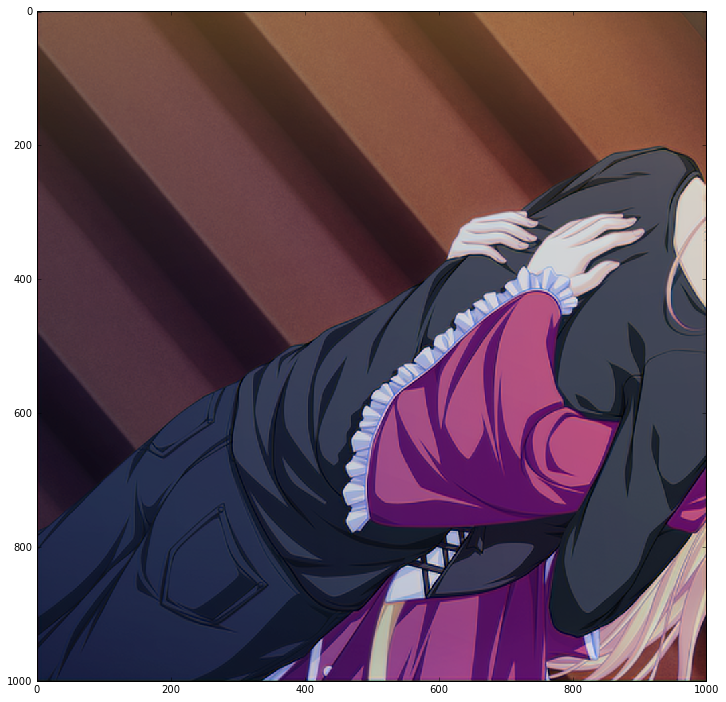

In [14]:
plt.figure(figsize = (12,12))
plt.imshow(sample[0],interpolation='nearest', aspect='auto')

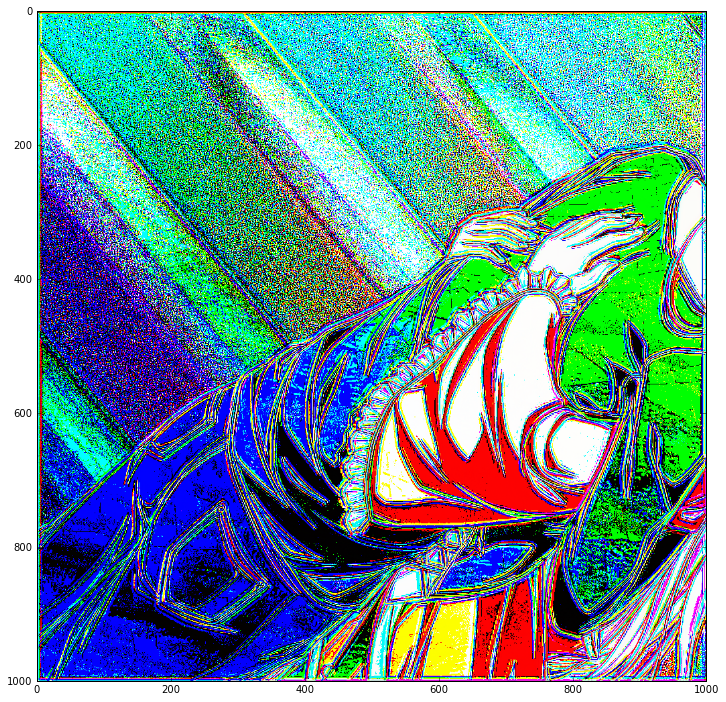

In [15]:
plt.figure(figsize = (18,12))
shape = sample[0].shape
diff_flat = abs(np.reshape(sample[0]-out_image_t[0],[-1]))
diff = np.reshape(diff_flat,shape)
plt.imshow(diff)

In [ ]:
flat = np.reshape(out_image_t[0],[-1])
min(flat)

In [26]:
output_number = 36
rezoomed = misc.imresize(in_image[0],[OUTPUT_SIZE.h, OUTPUT_SIZE.w])
#output_number = output_number + 1
misc.imsave("data/anime wallpapers/generated_output/"+str(output_number)+"_output.png", sample[0])
misc.imsave("data/anime wallpapers/generated_output/"+str(output_number)+"_input.png", in_image_t[0])
misc.imsave("data/anime wallpapers/generated_output/"+str(output_number)+"_original.png", out_image_t[0])
misc.imsave("data/anime wallpapers/generated_output/"+str(output_number)+"_diff.png", sample[0]-out_image_t[0])
print("Created images with number = "+str(output_number))

Created images with number = 36


In [9]:
saver = tf.train.Saver(upscale_model.variables)

In [23]:
saver.save(sess, 'saves/m3-40', global_step=1)

'saves/m3-40-1'

In [10]:
saver.restore(sess,'saves/m3-40-1')

In [12]:
#Clears everything
sess.close()
tf.reset_default_graph()